# Mesh Construction

This tutorial introduces the basics of mesh construction for the 
`puncturedfem` package.

Unlike convential meshes, the fundamental object in a `puncturedfem` mesh 
are the *edges*, rather than the *vertices*. 

In the first section, we demonstrate how to define an `edge` object. In the 
second section, we will see how to construct a mesh cell as a `cell` object.
In the third section, we will address how to build a `mesh` object.

In [1]:
import puncturedfem as pf
import numpy as np
import matplotlib.pyplot as plt

## Edges

An edge $e$ is taken to be a $C^2$ smooth curve in $\mathbb{R}^2$
parameterized by $x(t)$ for $0\leq t\leq 2\pi$.
We refer to $x(0)$ as the *anchor point* and $x(2\pi)$ as the 
*terminal point*, and $x(0),x(2\pi)$ are referred to collectively as the 
*endpoints*. We make the following assumptions:
* The edge $e$ is nontrivial: $e$ is not a single point.
* The edge $e$ is nonselfintersecting: $x(t_1)\neq x(t_2)$ 
  for all $0<t_1<t_2<2\pi$.
* $x(\cdot)$ is regularizable: there is some fixed $\sigma>0$ such that
  $|x'(t)|\geq\sigma$ for all $0 < t < 2\pi$.

### Quadrature objects
To create the points $0=t_0 < t_1 < \cdots < t_{2n}=2\pi$ where $x(t)$ 
will be sampled, we will declare a quadrature scheme with a `quad` object.
For now, we will use the trapezoid rule, which uses the equispacing 
$t_k = hk$, where $h=\pi / n$ for a chosen natural number $n$.

In [2]:
q_trap = pf.quad.quad.quad(qtype='trap', n=16)
print(q_trap)

quad object 
	type	trap 
	n	16


We visualize the sampling of the points by plotting $t_k$.

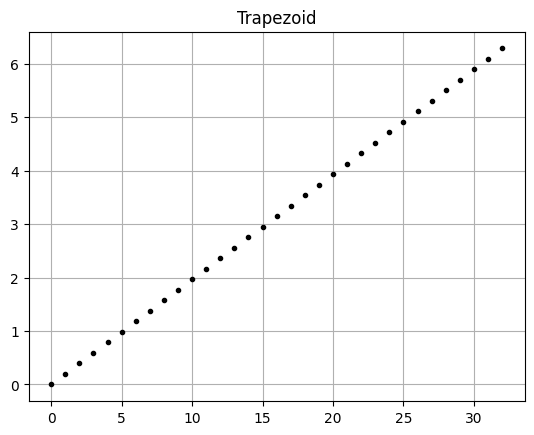

In [3]:
plt.figure()
plt.plot(q_trap.t, 'k.')
plt.title('Trapezoid')
plt.grid('on')
plt.show()

We also have the option of defining a Kress quadrature. The sampled points 
are clustered near the endpoints, and the parameter $p\geq2$ controls the 
strength of this clustering. (The default value is $p=7$.) 
We recommend using a Kress quadrature whenever dealing with boundaries that 
have corners, as we will discuss in the section on constructing mesh cells.

quad object 
	type	kress_7 
	n	16


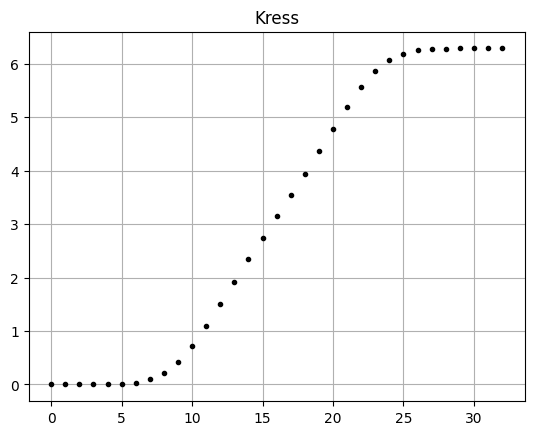

In [4]:
q_kress = pf.quad.quad.quad(qtype='kress', n=16)
print(q_kress)

plt.figure()
plt.plot(q_kress.t, 'k.')
plt.title('Kress')
plt.grid('on')
plt.show()

## Edges
### Loading from the edge library
In the directory `puncturedfem/mesh/edgelib` are several `.py` files,
each of which parameterizes an edge. 

In [5]:
e1 = pf.mesh.edge.edge(etype='line', q=q_trap)
print(e1)

id:        []
etype:     line
qtype:     trap
num_pts:   33



The `id` attribute is an optional label we can give an edge, 
which is useful when dealing with a large collection of edges.

In [6]:
e2 = pf.mesh.edge.edge(etype='line', q=q_kress, id='this_edge_uses_kress')
print(e2)

id:        this_edge_uses_kress
etype:     line
qtype:     kress_7
num_pts:   33



Some edge types require additional arguments. For example, the `sine_wave`
edge must have the amplitude and frequency specified.

In [7]:
e3 = pf.mesh.edge.edge(etype='sine_wave', q=q_kress, amp=0.2, freq=2)
print(e3)

id:        []
etype:     sine_wave
qtype:     kress_7
num_pts:   33



### Transorming edges
By default, edges with distinct endpoints are taken to connect the origin to
the point $(1,0)$. Typically, these are not the points we wish to connect.
Through rigid body motion and rescaling, we can connect any two distinct points by calling 
the `join_points()` method.

In [8]:
e2.join_points([1,1], [0,0.5])
e3.join_points([0,0.2], [1,0.4])

To visualize our edges, we call `pf.plot.edges()`, which takes as an argument
the list of edges we wish to plot.

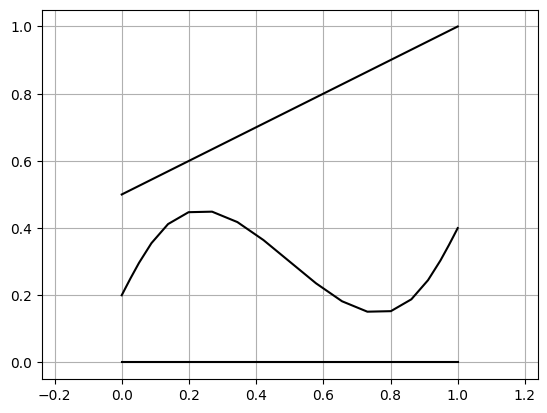

In [9]:
pf.plot.edges.edges([e1,e2,e3])

To see how the edges are oriented, we set the `orientation` argument to `True`.

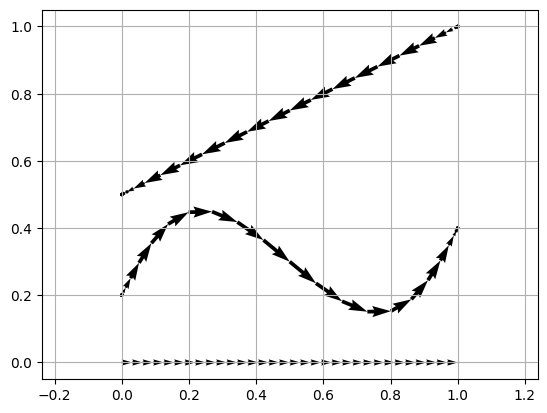

In [10]:
pf.plot.edges.edges([e1,e2,e3], orientation=True)

We can also call the `rotate()`, `dialate()`, and `translate()` methods
to perform these transfomations manually. (Note that the rotation angle is
assumed to be in degrees, counterclockwise from the positive horizonal axis.)

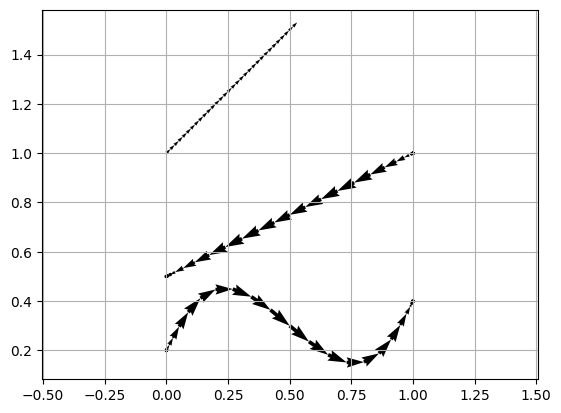

In [11]:
e1.rotate(45)
e1.dialate(0.75)
e1.translate([0,1])
pf.plot.edges.edges([e1,e2,e3], orientation=True)

An important operation is reversing the orientation of an edge.

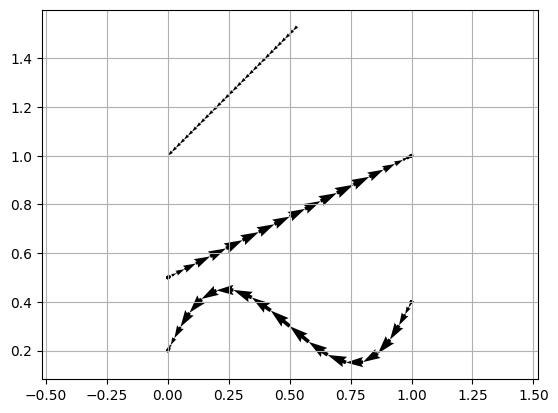

In [12]:
e1.reverse_orientation()
e2.reverse_orientation()
e3.reverse_orientation()
pf.plot.edges.edges([e1,e2,e3], orientation=True)

### Defining custom edges
In the event that we need an edge that is not provided in the `edgelib` folder,
we can add to the edge library as follows. 
1. Create a file `puncturedfem/mesh/edgelib/mycurve.py`, where `mycurve` will
   be the name of the curve that will be called during the initialization 
   of the edge object. 
2. Import the `numpy` package.
3. In `mycurve.py`, define three functions called `_x()`, `_dx()`, and `_ddx()`.
   These will define $x(t)$, $x'(t)$, and $x''(t)$ respectively.
4. Each of these three functions will return a $2\times (2n+1)$ array,
   where $2n+1$ is the number of sampled points specified by the chosen
   `quad` object.
5. Row 0 of each array contains the $x_1$ component, and row 1 contains the 
   $x_2$ component.
6. Unpack any additional arguments from `**kwargs`.

The contents of `mycurve.py` will look generically like the following:

	"""
	A short description of the curve.

	A description of any parameters that are used.
	"""

	import numpy as np

	def _x(t, **kwargs):

		my_parameter = kwargs['my_parameter']

		x = np.zeros((2,len(t)))
		x[0,:] = 	# the x_1 component
		x[1,:] = 	# the x_2 component

		return x

	def _dx(t, **kwargs):

		my_parameter = kwargs['my_parameter']

		dx = np.zeros((2,len(t)))
		dx[0,:] = 	# the derivative of the x_1 component wrt t
		dx[1,:] = 	# the derivative of the x_2 component wrt t

		return dx

	def _ddx(t, **kwargs):

		my_parameter = kwargs['my_parameter']

		ddx = np.zeros((2,len(t)))
		ddx[0,:] = 	# the second derivative of the x_1 component wrt t
		ddx[1,:] = 	# the second derivative of the x_2 component wrt t
		
		return ddx

## Mesh Cells
A mesh cell $K$ is an open, bounded, connected region with a 
piecewise $C^2$ smooth boundary.
In code, we represent `cell` objects as a list of `edge` objects,
which define the boundary $\partial K$.
The collection of these edges must satisfy the following:
* Two distinct edges are permitted to intersect only at their endpoints.  
* No slits or cusps: interior angle between two incident edges is strictly 
  between $0$ and $2\pi$.
* The union of all edges is a union of simple closed contours.
* The edges on the *outer boundary* $\partial K_0$ are oriented such that
  $\partial K_0$ is oriented counterclockwise.
* The edges on an *inner boundary* $\partial K_j$ are oriented such that
  $\partial K_j$ is oriented clockwise.
  
The *outer boundary* refers to the the boundary of the minimal open, 
simply-connected set $K_0$ containing $K$.
An *inner boundary* is the boundary of a hole $K_j$.

### Square with circular hole

To initialize a cell object, we must supply a list of edges that define the 
boundary. For our first example, we will build a unit square.

In [13]:
# initialize list of edges as empty list
edge_list1 = []

# bottom: (0,0) to (1,0)
e = pf.mesh.edge.edge(etype='line', q=q_kress)
e.join_points([0,0], [1,0])
edge_list1.append(e)

# right: (1,0) to (1,1)
e = pf.mesh.edge.edge(etype='line', q=q_kress)
e.join_points([1,0], [1,1])
edge_list1.append(e)

# top: (1,1) to (0,1)
e = pf.mesh.edge.edge(etype='line', q=q_kress)
e.join_points([1,1], [0,1])
edge_list1.append(e)

# left: (0,1) to (0,0)
e = pf.mesh.edge.edge(etype='line', q=q_kress)
e.join_points([0,1], [0,0])
edge_list1.append(e)

Let's check that we have oriented the edges correctly.

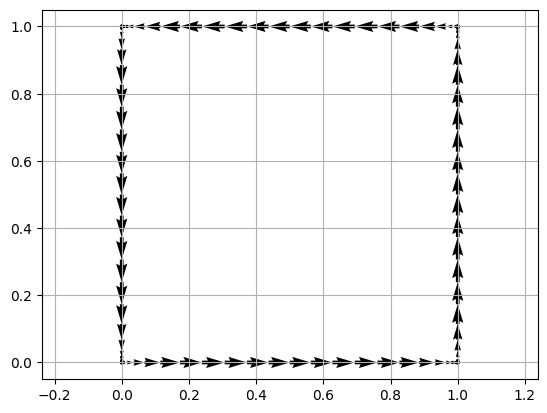

In [14]:
pf.plot.edges.edges(edge_list1, orientation=True)

The orientation of the boundary is indeed counterclockwise, as desired.
We are now ready to initialize a `cell` object.

In [15]:
K1 = pf.mesh.cell.cell(edge_list=edge_list1)
print(K1)

num_edges: 		4
num_holes: 		0
num_pts: 		128
contours: 		[[0, 1, 2, 3]]
ext_pt: 		[-1.0, -1.0]



Let's try adding a circular hole.

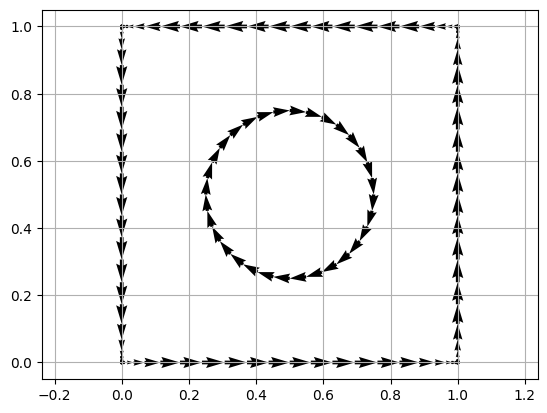

In [16]:
edge_list2 = edge_list1

# circular inner boundary
e = pf.mesh.edge.edge(etype='circle', q=q_trap)
e.reverse_orientation()
e.dialate(0.25)
e.translate([0.5, 0.5])
edge_list2.append(e)

# check orientation
pf.plot.edges.edges(edge_list2, orientation=True)

Notice that the inner boundary is oriented clockwise. 
We are ready to initialize a `cell` object.

In [17]:
K2 = pf.mesh.cell.cell(edge_list=edge_list2)
print(K2)

num_edges: 		5
num_holes: 		1
num_pts: 		160
contours: 		[[0, 1, 2, 3], [4]]
ext_pt: 		[-1.0, -1.0]
hole_int_pts (x): 	[0.5]
hole_int_pts (y): 	[0.5]



### Ghost

To show off some capabilities, we consider a more whimsical example.
Notice that the order in which the edges are listed is arbitrary:
the holes and outer boundary are identified automatically,
with the indices ordered so as to respect the contour orientation.

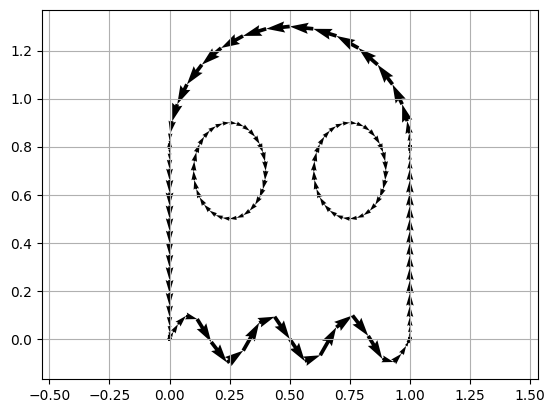

num_edges: 		6
num_holes: 		2
num_pts: 		192
contours: 		[[1, 4, 2, 5], [0], [3]]
ext_pt: 		[2.0, 2.3]
hole_int_pts (x): 	[0.75 0.25]
hole_int_pts (y): 	[0.7 0.7]



In [18]:
edge_list3 = []

# (0) right hole
e = pf.mesh.edge.edge(etype='ellipse', q=q_trap, a=0.15, b=0.2)
e.translate([0.75,0.7])
e.reverse_orientation()
edge_list3.append(e)

# (1) left: line
e = pf.mesh.edge.edge(etype='line', q=q_kress)
e.join_points([0,0.8], [0,0])
edge_list3.append(e)

# (2) right: line
e = pf.mesh.edge.edge(etype='line', q=q_kress)
e.join_points([1,0], [1,0.8])
edge_list3.append(e)

# (3) left hole
e = pf.mesh.edge.edge(etype='ellipse', q=q_trap, a=0.15, b=0.2)
e.translate([0.25,0.7])
e.reverse_orientation()
edge_list3.append(e)

# (4) bottom: squiggles
e = pf.mesh.edge.edge(etype='sine_wave', q=q_kress, amp=0.1, freq=6)
edge_list3.append(e)

# (5) top: half-circle
e = pf.mesh.edge.edge(etype='circular_arc', q=q_kress, H=0)
e.reflect_across_x_axis()
e.join_points([1,0.8], [0,0.8])
edge_list3.append(e)

# check orientation
pf.plot.edges.edges(edge_list3, orientation=True)

# define mesh cell
K = pf.mesh.cell.cell(edge_list=edge_list3)
print(K)

## Meshes
Coming soon!